In [1]:
!pip install scikit-learn umap-learn scikit-fuzzy pandas numpy matplotlib seaborn ipywidgets -q

In [2]:
# Importing plotting libraries
import matplotlib.pyplot as plt  # For creating static, interactive, and animated visualizations
import seaborn as sns            # For making statistical graphics and visualization

# Importing dimensionality reduction and clustering libraries
import umap                      # For Uniform Manifold Approximation and Projection (UMAP)
import pandas as pd              # For data manipulation and analysis
import numpy as np               # For numerical operations on arrays
import skfuzzy as fuzz           # For Fuzzy Clustering and membership functions

# Importing preprocessing and evaluation metrics
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler  # For feature scaling
from sklearn.metrics import silhouette_score, davies_bouldin_score               # For clustering evaluation metrics
from sklearn.model_selection import ParameterGrid                                # For generating parameter combinations

# Importing dimensionality reduction techniques
from sklearn.decomposition import PCA, TruncatedSVD  # For Principal Component Analysis and Singular Value Decomposition

# Importing clustering algorithms
from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering, MeanShift  # For various clustering methods

# Importing manifold learning techniques
from sklearn.manifold import TSNE  # For t-Distributed Stochastic Neighbor Embedding (t-SNE) for dimensionality reduction

# Importing a utility for creating synthetic data
from sklearn.datasets import make_blobs  # For generating synthetic datasets with blob structure

In [3]:
class ClusteringModel:
    def __init__(self, raw_tensor, verbose=False):
        """
        Initialize the ClusteringModel with raw data and optional verbosity.

        Parameters:
        - raw_tensor: The raw data tensor to be used for clustering.
        - verbose: If True, prints additional information during initialization.
        """
        self.raw_tensor = raw_tensor
        self.scalers = {
            'MinMaxScaler': MinMaxScaler(),
            'StandardScaler': StandardScaler(),
            'RobustScaler': RobustScaler()
        }
        self.reducers = {
            'PCA': PCA,
            'UMAP': umap.UMAP,
            'SVD': TruncatedSVD
        }
        self.raw_tensor_scaled = {name: scaler.fit_transform(raw_tensor) for name, scaler in self.scalers.items()}
        self.reduced_tensor = {}
        self.models = {
            'DBSCAN': {
                'eps': [round(i * 0.1, 1) for i in range(3, 6)],
                'min_samples': list(range(16, 16 * 4, 16))
            },
            'KMeans': {'n_clusters': list(range(5, 8))},
            'AgglomerativeClustering': {'n_clusters': list(range(5, 8))},
            'MeanShift': {'bandwidth': [1, 2, 3]},
            'FuzzyCMeans': {
                            'n_clusters': list(range(5, 8)),
                            'm': list(range(2, 5))
            }
        }
        self.best_model = None
        self.best_combination = None
        self.best_scaler = None
        self.best_reducer = None
        self.seed = 42
        
        if verbose:
            print("[Init]: Initializing the class ... ")

    def reduce_dimension(self, method='PCA', n_components=2, verbose=False):
        """
        Reduce the dimensionality of the raw tensor using the specified method.

        Parameters:
        - method: The dimensionality reduction method to use ('PCA', 'UMAP', 'SVD').
        - n_components: Number of components for the reduction.
        - verbose: If True, prints additional information during the reduction.

        Returns:
        - A dictionary with the reduced tensors for each scaler.
        """
        if verbose:
            print(f"[Dimensionality Reduction]: Reducing dimensions using {method} ... ")
        
        if method not in self.reducers:
            raise ValueError(f"Unsupported dimensionality reduction method: {method}")
        
        reducer_cls = self.reducers[method]
        kwargs = {'n_components': n_components}
               
        reducer = reducer_cls(**kwargs)
        
        self.reduced_tensor = {scaler_name: reducer.fit_transform(scaled_data) 
                            for scaler_name, scaled_data in self.raw_tensor_scaled.items()}
        return self.reduced_tensor

    def fit_models(self, use_reduction=True, use_scalers=True, verbose=False):
        """
        Fit various clustering models to the data using optional scaling and dimensionality reduction.

        Parameters:
        - use_reduction: If True, apply dimensionality reduction before fitting models.
        - use_scalers: If True, apply scaling before fitting models.
        - verbose: If True, prints additional information during the model fitting.

        Returns:
        - A list of dictionaries containing evaluation metrics for each model configuration.
        """
        results = []

        scalers_to_use = self.scalers.items() if use_scalers else [('None', self.raw_tensor)]
        reducers_to_use = self.reducers.items() if use_reduction else [('None', None)]

        for scaler_name, scaler in scalers_to_use:
            if scaler_name != 'None':
                scaled_data = scaler.fit_transform(self.raw_tensor)
                tensor_to_use = self.reduced_tensor.get(scaler_name, scaled_data) if use_reduction else scaled_data
            else:
                tensor_to_use = self.reduced_tensor.get(scaler_name, self.raw_tensor) if use_reduction else self.raw_tensor

            for reducer_name, reducer_cls in reducers_to_use:
                if reducer_name != 'None' and use_reduction:
                    kwargs = {'n_components': 2}
                    reducer = reducer_cls(**kwargs)
                    tensor_to_use = reducer.fit_transform(tensor_to_use)
                
                for model_name, parameters in self.models.items():
                    grid = self.generate_combinations(parameters)
                    
                    if verbose:
                        print(f"[ParamGrid]: Estimating the models for {model_name} with {scaler_name} and reducer {reducer_name} ... ")

                    for combination in grid:
                        if model_name == 'FuzzyCMeans':
                            labels = self._fit_fuzzy_cmeans(tensor_to_use, combination)
                        else:
                            model = self._create_model(model_name, combination)
                            labels = model.fit_predict(tensor_to_use)

                        n_labels = len(np.unique(labels))

                        if n_labels > 1:
                            silhouette = silhouette_score(tensor_to_use, labels)
                            db_index = davies_bouldin_score(tensor_to_use, labels)
                        else:
                            silhouette = -1
                            db_index = np.nan

                        results.append({
                            'scaler': scaler_name,
                            'reducer': reducer_name,
                            'model': model_name,
                            'combination': combination,
                            'silhouette_score': silhouette,
                            'davies_bouldin_score': db_index,
                            'groups': n_labels
                        })

                if verbose:
                    print(f"[Evaluation]: All the models with scalers and reducers were evaluated ... ")

        return results

    @staticmethod
    def generate_combinations(parameters):
        """
        Generate all possible combinations of parameters for grid search.

        Parameters:
        - parameters: A dictionary of parameter names and their possible values.

        Returns:
        - An iterator over the combinations of parameters.
        """
        return ParameterGrid(parameters)

    def _create_model(self, model_name, combination):
        """
        Create a clustering model instance based on the specified model name and parameters.

        Parameters:
        - model_name: The name of the model to create ('DBSCAN', 'KMeans', 'AgglomerativeClustering', 'MeanShift', 'FuzzyCMeans').
        - combination: A dictionary of parameters for the model.

        Returns:
        - An instance of the specified clustering model.

        Raises:
        - ValueError if the model name is unsupported.
        """
        if model_name == 'DBSCAN':
            return DBSCAN(eps=combination['eps'], min_samples=combination['min_samples'])
        elif model_name == 'KMeans':
            return KMeans(n_clusters=combination['n_clusters'], random_state=self.seed)
        elif model_name == 'AgglomerativeClustering':
            return AgglomerativeClustering(n_clusters=combination['n_clusters'])
        elif model_name == 'MeanShift':
            return MeanShift(bandwidth=combination['bandwidth'])
        elif model_name == 'FuzzyCMeans':
            return None
        else:
            raise ValueError(f"Unsupported model: {model_name}")

    def _fit_fuzzy_cmeans(self, data, combination):
        """
        Fit a Fuzzy C-Means clustering model to the data and return the cluster labels.

        Parameters:
        - data: The data to cluster.
        - combination: A dictionary of parameters for the Fuzzy C-Means model.

        Returns:
        - An array of cluster labels for each data point.
        """
        n_clusters = combination['n_clusters']
        m = combination['m']
        
        cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
            data.T, n_clusters, m, error=0.005, maxiter=1000, init=None
        )
        
        cluster_labels = np.argmax(u, axis=0)
        return cluster_labels

    def select_best_model(self, metric='silhouette', use_reduction=True, use_scalers=True, n_min=5, n_max=7, verbose=False):
        """
        Select the best clustering model based on evaluation metrics and specified criteria.

        Parameters:
        - metric: The metric to use for selecting the best model ('silhouette' or 'davies_bouldin').
        - use_reduction: If True, consider dimensionality reduction.
        - use_scalers: If True, consider scaling.
        - n_min: Minimum number of clusters to consider.
        - n_max: Maximum number of clusters to consider.
        - verbose: If True, prints additional information during model selection.

        Returns:
        - A dictionary with the best model, parameters, scaler, and reducer.
        - A DataFrame with the filtered results.
        """
        results = self.fit_models(use_reduction=use_reduction, use_scalers=use_scalers, verbose=verbose)
        df_results = pd.DataFrame(results)

        df_filtered = df_results[
            (df_results['groups'].between(n_min, n_max)) &
            (df_results['silhouette_score'] > 0)
        ].reset_index(drop=True)

        if df_filtered.empty:
            raise ValueError("[WARNING]: No valid models found with the given criteria.")

        if metric == 'silhouette':
            df_sorted = df_filtered.sort_values(by='silhouette_score', ascending=False)
        elif metric == 'davies_bouldin':
            df_sorted = df_filtered.sort_values(by='davies_bouldin_score', ascending=True)
        else:
            raise ValueError(f"Unsupported metric: {metric}")

        best_model_row = df_sorted.iloc[0]
        self.best_model = best_model_row['model']
        self.best_combination = best_model_row['combination']
        self.best_scaler = best_model_row['scaler']
        self.best_reducer = best_model_row['reducer']
        
        if verbose:
            print("[Selection]: Best model was selected: ")
            
        return {
            'best_model': self.best_model,
            'best_parameters': self.best_combination,
            'scaler': self.best_scaler,
            'reducer': self.best_reducer
        }, df_sorted

    def estimate_best_model(self, use_reduction=True, use_scalers=True, verbose=False):
        """
        Estimate the cluster labels using the best selected model.

        Parameters:
        - use_reduction: If True, apply dimensionality reduction using the best reducer.
        - use_scalers: If True, apply scaling using the best scaler.
        - verbose: If True, prints additional information during label estimation.

        Returns:
        - An array of cluster labels for each data point.

        Raises:
        - ValueError if no best model has been selected.
        """
        if self.best_model is None or self.best_combination is None:
            raise ValueError("[ERROR]: No best model selected. Run select_best_model first.")
        
        if not use_reduction or self.best_reducer == 'None':
            tensor_to_use = self.raw_tensor
        else:
            tensor_to_use = self.reduced_tensor.get(self.best_scaler, self.raw_tensor_scaled.get(self.best_scaler, self.raw_tensor))
        
        if use_scalers and self.best_scaler != 'None':
            tensor_to_use = self.raw_tensor_scaled.get(self.best_scaler, self.raw_tensor)

        model = self._create_model(self.best_model, self.best_combination)

        if self.best_model == 'FuzzyCMeans':
            labels = self._fit_fuzzy_cmeans(tensor_to_use, self.best_combination)
        else:
            labels = model.fit_predict(tensor_to_use)
        if verbose:
            print("[Best Model]: Best model label estimated")
            
        return labels
    
    def fit_tsne(self, n_components=2, perplexity=30, learning_rate=200):
        """
        Fit t-SNE on the data using the best model and obtain 2D embeddings.

        Parameters:
        - n_components: Number of dimensions for t-SNE.
        - perplexity: Perplexity parameter for t-SNE.
        - learning_rate: Learning rate parameter for t-SNE.

        Raises:
        - ValueError if the best model has not been selected yet.
        """
        if self.best_model is None or self.best_combination is None:
            raise ValueError("[WARNING]: Best model has not been selected yet. Please run select_best_model first.")
        
        if self.best_reducer == 'None':
            tensor_to_use = self.raw_tensor
        else:
            tensor_to_use = self.reduced_tensor.get(self.best_scaler, self.raw_tensor_scaled.get(self.best_scaler, self.raw_tensor))

        best_model = self._create_model(self.best_model, self.best_combination)
        self.labels = best_model.fit_predict(tensor_to_use)
        
        tsne = TSNE(n_components=n_components, perplexity=perplexity, learning_rate=learning_rate, random_state=self.seed)
        self.tsne_results = tsne.fit_transform(tensor_to_use)

    def plot_tsne(self):
        """
        Plot the t-SNE results to visualize the clustering results in 2D.

        Raises:
        - ValueError if t-SNE results or labels are not available. Please run fit_tsne first.
        """
        if self.tsne_results is None or self.labels is None:
            raise ValueError("[WARNING]: t-SNE results or labels are not available. Please run fit_tsne first.")
        
        tsne_df = pd.DataFrame(self.tsne_results, columns=['Dimension 1', 'Dimension 2'])
        tsne_df['Cluster'] = self.labels
        
        plt.figure(figsize=(6, 4))
        sns.scatterplot(
            x='Dimension 1', y='Dimension 2', hue='Cluster', palette='tab10',
            data=tsne_df, legend='full', alpha=0.7
        )
        plt.title('t-SNE Visualization of Clustering Results')
        plt.xlabel('Dimension 1')
        plt.ylabel('Dimension 2')
        plt.legend(title='Cluster')
        plt.show()

Best selected model:
{'best_model': 'KMeans', 'best_parameters': {'n_clusters': 5}, 'scaler': 'MinMaxScaler', 'reducer': 'PCA'}


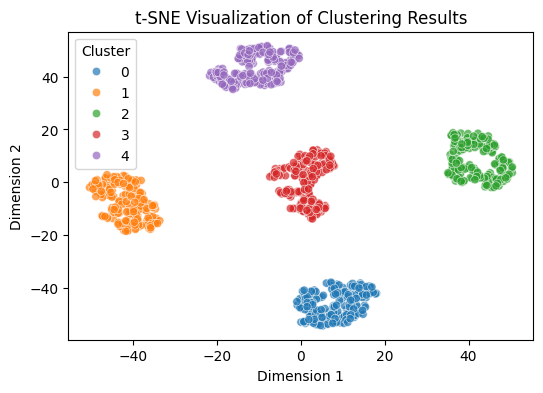

In [4]:
# Set a random seed for reproducibility
SEED = 42

# Generate a sample dataset with blobs
X, _ = make_blobs(n_samples=1000, centers=5, cluster_std=0.4)

# Create an instance of the ClusteringModel with the generated data
clustering_model = ClusteringModel(X)

# Select the best model based on the silhouette score
best_model_info, df_models = clustering_model.select_best_model()

# Estimate the labels using the best model
labels = clustering_model.estimate_best_model()

# Print the best model and its parameters
print("Best selected model:")
print(best_model_info)

# Initialize t-SNE for dimensionality reduction
tsne_model = clustering_model.fit_tsne()

# Plot the t-SNE results
clustering_model.plot_tsne()

In [5]:
# Check the models results and its metrics
df_models

,scaler,reducer,model,combination,silhouette_score,davies_bouldin_score,groups
0,MinMaxScaler,PCA,KMeans,{'n_clusters': 5},0.878710,0.171758,5
3,MinMaxScaler,PCA,AgglomerativeClustering,{'n_clusters': 5},0.878710,0.171758,5
6,MinMaxScaler,PCA,FuzzyCMeans,"{'m': 2, 'n_clusters': 5}",0.878710,0.171758,5
12,MinMaxScaler,PCA,FuzzyCMeans,"{'m': 4, 'n_clusters': 5}",0.878710,0.171758,5
9,MinMaxScaler,PCA,FuzzyCMeans,"{'m': 3, 'n_clusters': 5}",0.878710,0.171758,5
...,...,...,...,...,...,...,...
66,StandardScaler,PCA,FuzzyCMeans,"{'m': 2, 'n_clusters': 7}",0.662629,0.659513,7
11,MinMaxScaler,PCA,FuzzyCMeans,"{'m': 3, 'n_clusters': 7}",0.659716,0.669644,7
14,MinMaxScaler,PCA,FuzzyCMeans,"{'m': 4, 'n_clusters': 7}",0.658854,0.670113,7
2,MinMaxScaler,PCA,KMeans,{'n_clusters': 7},0.656607,0.683281,7
